In [2]:
import os
os.listdir('fish_screenshots_test/')

['screenshots0000_3178',
 'screenshots0000_3179',
 'screenshots0000_3180',
 'screenshots0000_3181',
 'screenshots0000_3182',
 'screenshots0000_3183',
 'screenshots0000_3184',
 'screenshots0000_3185',
 'screenshots0000_3186']

In [3]:
os.getcwd()

'C:\\Users\\user'

In [385]:
import torch
import numpy as np
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch import nn
from torch.nn import functional as F
import random
import torchvision.utils as vutils
import argparse
import math

from torchsummary import summary

# Root directory for dataset
# dataroot = "fish_screenshots_test/"
dataroot = "fish_screenshots_test/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 256

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

embedding_image_size = 4

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector
nz = 100

# Number of training epochs
num_epochs = 50 # Original is 5 on a dataset of 1 million

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

num_training_updates = 15000

num_hiddens = 128

embedding_dim = 128
num_embeddings = 128

commitment_cost = 0.25

decay = 0.99

learning_rate = 1e-3

In [360]:
# Set random seed for reproducibility
seed = 1141
# seed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", seed)
random.seed(seed)
torch.manual_seed(seed)

Random Seed:  1141


In [361]:
train_ds = ImageFolder(
    root=dataroot,
    transform = transforms.Compose([transforms.CenterCrop([600-64,800-64]),
                               transforms.Resize([image_size,image_size]),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),])
)

dataloader = DataLoader(train_ds, batch_size, shuffle=True)

In [364]:
var = []
i = 0
for img in dataloader:
    var.append(torch.var(img[0]))
    i+=1
    if i > 100:
        print('break')
        break

In [365]:
data_variance  = sum(var) / len(var)
data_variance = data_variance.item()
data_variance

0.013796272687613964

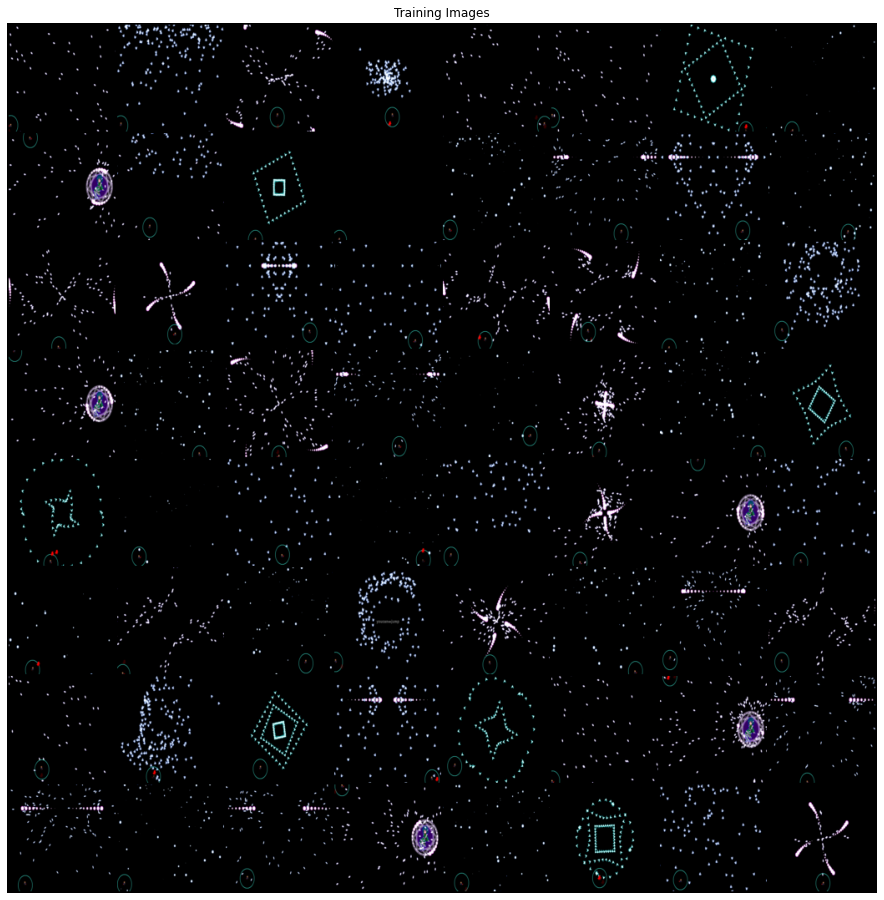

In [362]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(16, 16))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))


In [10]:
next(iter(dataloader))[0].shape

torch.Size([128, 3, 128, 128])

In [297]:
def calc_same_pad(i: int, k: int, s: int, d: int) -> int:
    return max((math.ceil(i / s) - 1) * s + (k - 1) * d + 1 - i, 0)

class Conv2dSame(torch.nn.Conv2d):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
#         print(x.size())
        ih, iw = x.size()[-2:]

        pad_h = calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])
        
        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]
            )
            
        x = F.conv2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
        
        return x
    
class ConvTranspose2dSame(torch.nn.ConvTranspose2d):

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        
        ih, iw = x.size()[-2:]
        ih *= 2
        iw *= 2

        pad_h = calc_same_pad(i=ih, k=self.kernel_size[0], s=self.stride[0], d=self.dilation[0])
        pad_w = calc_same_pad(i=iw, k=self.kernel_size[1], s=self.stride[1], d=self.dilation[1])
        
        x = F.conv_transpose2d(
            x,
            self.weight,
            self.bias,
            self.stride,
            self.padding,
            self.dilation,
            self.groups,
        )
        
        if pad_h > 0 or pad_w > 0:
            x = F.pad(
                x, list(map(lambda x: -x * self.stride[0], [pad_w // 2, pad_w - pad_w // 2, pad_h // 2, pad_h - pad_h // 2]))
            )
            
        return x

In [224]:
def power_calc(number, base):
    power = 0
    
    if (number < 1):
        raise ValueError(f'not power of {base}')
        
    while (number != 1):
            if (number % base != 0):
                raise ValueError(f'not power of {base}')
            number = number // base
            power += 1
             
    return power

In [225]:
power_calc(128,2)

7

In [226]:
list(reversed(np.arange(1,4)))

[3, 2, 1]

In [386]:
class Encoder(nn.Module):
    def __init__(self, in_channels, num_hiddens, embedding_dim, image_size, embedding_image_size):
        super(Encoder, self).__init__()
        
        num_of_convs = power_calc(image_size,2) - power_calc(embedding_image_size,2)
        
        conv_layers = [Conv2dSame(in_channels=in_channels,
                                 out_channels=num_hiddens // 2**(num_of_convs - 1),
                                 kernel_size=3,
                                 stride=2), nn.ReLU()]
        
        for i in reversed(range(1, num_of_convs)):
            conv_layers.append(Conv2dSame(in_channels=num_hiddens//2**(i),
                                 out_channels=num_hiddens//2**(i-1),
                                 kernel_size=3,
                                 stride=2))
            conv_layers.append(nn.ReLU())

        self._convs = nn.Sequential(*conv_layers)
        
        if num_hiddens != embedding_dim:
            self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                          out_channels=embedding_dim,
                                          kernel_size=1, 
                                          stride=1)

    def forward(self, x):
        
        x = self._convs(x)
        
        if num_hiddens != embedding_dim:
            x = self._pre_vq_conv(x)
        
        return x

In [387]:
encoder = Encoder(3, num_hiddens, embedding_dim, image_size, embedding_image_size).to(device)

In [388]:
summary(encoder, (3, image_size, image_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
        Conv2dSame-1            [-1, 8, 64, 64]             224
              ReLU-2            [-1, 8, 64, 64]               0
        Conv2dSame-3           [-1, 16, 32, 32]           1,168
              ReLU-4           [-1, 16, 32, 32]               0
        Conv2dSame-5           [-1, 32, 16, 16]           4,640
              ReLU-6           [-1, 32, 16, 16]               0
        Conv2dSame-7             [-1, 64, 8, 8]          18,496
              ReLU-8             [-1, 64, 8, 8]               0
        Conv2dSame-9            [-1, 128, 4, 4]          73,856
             ReLU-10            [-1, 128, 4, 4]               0
Total params: 98,384
Trainable params: 98,384
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 0.97
Params size (MB): 0.38
Estimated Tot

In [389]:
class Decoder(nn.Module):
    def __init__(self, out_channels, num_hiddens, embedding_dim,  image_size, embedding_image_size):
        super(Decoder, self).__init__()
        
        if num_hiddens != embedding_dim:
            self.posq_vq_conv = nn.Conv2d(in_channels=embedding_dim,
                                     out_channels=num_hiddens,
                                     kernel_size=1, 
                                     stride=1)
        
        num_of_convs_transes = power_calc(image_size,2) - power_calc(embedding_image_size,2)
        
        conv_trans_layers = [ConvTranspose2dSame(in_channels=num_hiddens,
                                 out_channels=num_hiddens // 2,
                                 kernel_size=3,
                                 stride=2), nn.ReLU()]
        
        for i in range(power_calc(embedding_image_size,2), power_calc(image_size,2) - 1):
            
            if i != power_calc(image_size,2) - 2:
                conv_trans_layers.append(ConvTranspose2dSame(in_channels=num_hiddens//2**(i-1-power_calc(embedding_image_size,2)+2),
                                 out_channels=num_hiddens//2**(i-power_calc(embedding_image_size,2)+2),
                                 kernel_size=3,
                                 stride=2))
                conv_trans_layers.append(nn.ReLU())
            else:
                conv_trans_layers.append(ConvTranspose2dSame(in_channels=num_hiddens//2**(i-1-power_calc(embedding_image_size,2)+2),
                                 out_channels=out_channels,
                                 kernel_size=3,
                                 stride=2))
                conv_trans_layers.append(nn.Tanh())

        self._conv_transes = nn.Sequential(*conv_trans_layers)

    def forward(self, x):
        
        if num_hiddens != embedding_dim:
            x = self.posq_vq_conv(x)
        
        x = self._conv_transes(x)
        
        return x

In [390]:
decoder = Decoder(3, num_hiddens, 
                                embedding_dim,  image_size, embedding_image_size).to(device)

In [391]:
summary(decoder, (embedding_dim, 4, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
ConvTranspose2dSame-1             [-1, 64, 8, 8]          73,792
              ReLU-2             [-1, 64, 8, 8]               0
ConvTranspose2dSame-3           [-1, 32, 16, 16]          18,464
              ReLU-4           [-1, 32, 16, 16]               0
ConvTranspose2dSame-5           [-1, 16, 32, 32]           4,624
              ReLU-6           [-1, 16, 32, 32]               0
ConvTranspose2dSame-7            [-1, 8, 64, 64]           1,160
              ReLU-8            [-1, 8, 64, 64]               0
ConvTranspose2dSame-9          [-1, 3, 128, 128]             219
             Tanh-10          [-1, 3, 128, 128]               0
Total params: 98,259
Trainable params: 98,259
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.69
Params size (MB): 0.37
Estimate

In [392]:
class VectorQuantizerEMA(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, commitment_cost, decay, epsilon=1e-5):
        super(VectorQuantizerEMA, self).__init__()
        
        self._embedding_dim = embedding_dim
        self._num_embeddings = num_embeddings
        
        self._embedding = nn.Embedding(self._num_embeddings, self._embedding_dim)
        self._embedding.weight.data.normal_()
        self._commitment_cost = commitment_cost
        
        self.register_buffer('_ema_cluster_size', torch.zeros(num_embeddings))
        self._ema_w = nn.Parameter(torch.Tensor(num_embeddings, self._embedding_dim))
        self._ema_w.data.normal_()
        
        self._decay = decay
        self._epsilon = epsilon

    def forward(self, inputs):
        # convert inputs from BCHW -> BHWC
#         print(inputs.size())
        inputs = inputs.permute(0, 2, 3, 1).contiguous()
        input_shape = inputs.shape
        
        # Flatten input
        flat_input = inputs.view(-1, self._embedding_dim)
        
        # Calculate distances
        distances = (torch.sum(flat_input**2, dim=1, keepdim=True) 
                    + torch.sum(self._embedding.weight**2, dim=1)
                    - 2 * torch.matmul(flat_input, self._embedding.weight.t()))
            
        # Encoding
        encoding_indices = torch.argmin(distances, dim=1).unsqueeze(1)
        encodings = torch.zeros(encoding_indices.shape[0], self._num_embeddings, device=inputs.device)
        encodings.scatter_(1, encoding_indices, 1)
        
        # Quantize and unflatten
        quantized = torch.matmul(encodings, self._embedding.weight).view(input_shape)
        
        # Use EMA to update the embedding vectors
        if self.training:
            self._ema_cluster_size = self._ema_cluster_size * self._decay + \
                                     (1 - self._decay) * torch.sum(encodings, 0)
            
            # Laplace smoothing of the cluster size
            n = torch.sum(self._ema_cluster_size.data)
            self._ema_cluster_size = (
                (self._ema_cluster_size + self._epsilon)
                / (n + self._num_embeddings * self._epsilon) * n)
            
            dw = torch.matmul(encodings.t(), flat_input)
            self._ema_w = nn.Parameter(self._ema_w * self._decay + (1 - self._decay) * dw)
            
            self._embedding.weight = nn.Parameter(self._ema_w / self._ema_cluster_size.unsqueeze(1))
        
        # Loss
        e_latent_loss = F.mse_loss(quantized.detach(), inputs)
        loss = self._commitment_cost * e_latent_loss
        
        # Straight Through Estimator
        quantized = inputs + (quantized - inputs).detach()
        avg_probs = torch.mean(encodings, dim=0)
        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))
        
        # convert quantized from BHWC -> BCHW
        return loss, quantized.permute(0, 3, 1, 2).contiguous(), perplexity, encoding_indices

In [393]:
class VQ_VAE(nn.Module):
    def __init__(self, num_hiddens, 
                 num_embeddings, embedding_dim, image_size, embedding_image_size, commitment_cost, decay=0):
        super(VQ_VAE, self).__init__()
        
        self._encoder = Encoder(3, num_hiddens,
                                embedding_dim, image_size, embedding_image_size,)
        self._pre_vq_conv = nn.Conv2d(in_channels=num_hiddens, 
                                      out_channels=embedding_dim,
                                      kernel_size=1, 
                                      stride=1)
        if decay > 0.0:
            self._vq_vae = VectorQuantizerEMA(num_embeddings, embedding_dim, 
                                              commitment_cost, decay)
        else:
            self._vq_vae = VectorQuantizer(num_embeddings, embedding_dim,
                                           commitment_cost)
        self._decoder = Decoder(3, num_hiddens, 
                                embedding_dim,  image_size, embedding_image_size)

    def forward(self, x):
        z = self._encoder(x)
        loss, quantized, perplexity, _ = self._vq_vae(z)
#         print(quantized.shape)
        x_recon = self._decoder(quantized)
#         print(x_recon.shape)

        return loss, x_recon, perplexity

In [394]:
model = VQ_VAE(num_hiddens, num_embeddings, embedding_dim, image_size, embedding_image_size, commitment_cost, decay).to(device)

In [395]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in np.arange(30000):
    (data, _) = next(iter(dataloader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
#     print(data_recon.shape)
    recon_error = F.mse_loss(data_recon, data) / data_variance
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()
    
    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()



100 iterations
recon_error: 1.217
perplexity: 1.000

200 iterations
recon_error: 0.997
perplexity: 1.000

300 iterations
recon_error: 0.995
perplexity: 1.000

400 iterations
recon_error: 0.992
perplexity: 1.000

500 iterations
recon_error: 1.005
perplexity: 1.000

600 iterations
recon_error: 0.999
perplexity: 1.000

700 iterations
recon_error: 0.996
perplexity: 1.000

800 iterations
recon_error: 0.998
perplexity: 1.000

900 iterations
recon_error: 0.991
perplexity: 1.000

1000 iterations
recon_error: 0.945
perplexity: 2.532

1100 iterations
recon_error: 0.802
perplexity: 3.138

1200 iterations
recon_error: 0.773
perplexity: 10.413

1300 iterations
recon_error: 0.760
perplexity: 12.159

1400 iterations
recon_error: 0.742
perplexity: 18.894

1500 iterations
recon_error: 0.731
perplexity: 21.423

1600 iterations
recon_error: 0.719
perplexity: 23.691

1700 iterations
recon_error: 0.715
perplexity: 24.863

1800 iterations
recon_error: 0.714
perplexity: 26.668

1900 iterations
recon_error: 0

In [344]:
torch.save(model.state_dict(), 'VQ_VAE_models/im64x64_emb4x4-32-32_hid32_wrong.pt')

In [68]:
from scipy.signal import savgol_filter

In [69]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

Text(0.5, 0, 'iteration')

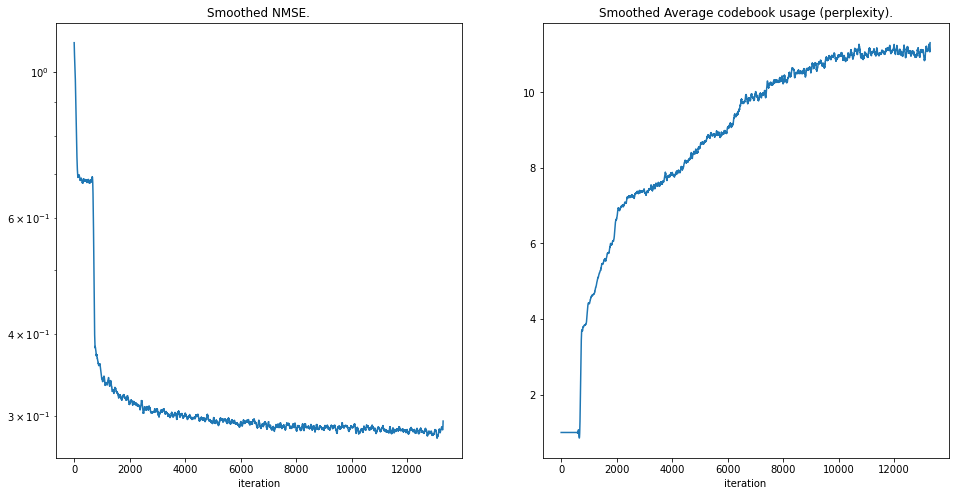

In [315]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [37]:
os.chdir('C:/Users/user/')

In [39]:
import cv2 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


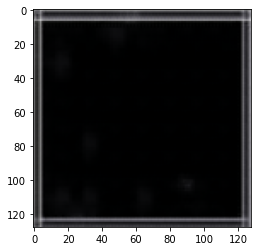

In [342]:
_, data_recon, _ = model(x.to(device))
img = data_recon[7].cpu().detach().numpy().transpose(1,2,0)
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

ValueError: num must be 1 <= num <= 32, not 33

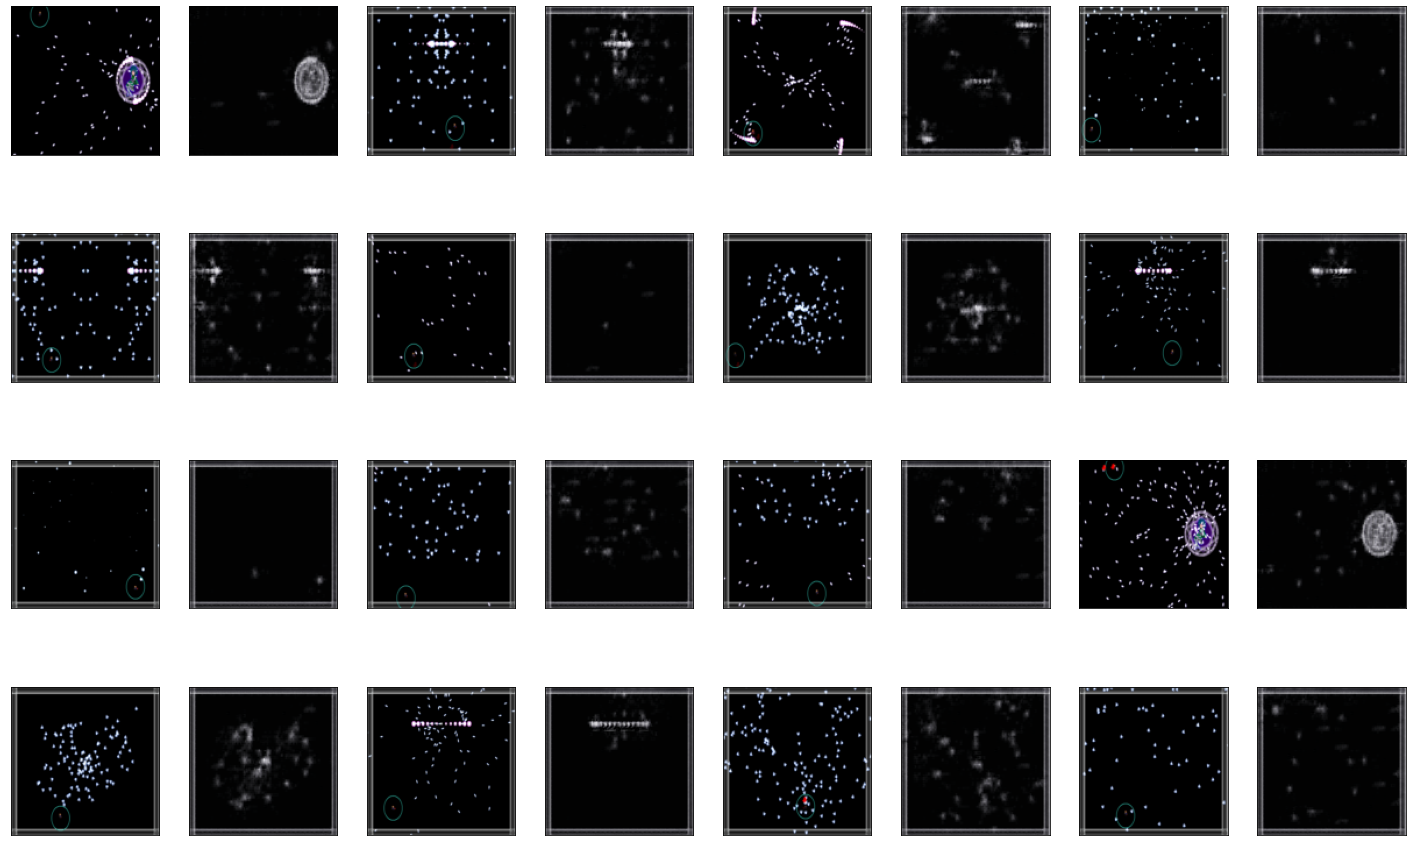

In [351]:
iter_dl = iter(dataloader)
x = next(iter_dl)
x = x[0]
_, data_recon, _ = model(x.to(device))

fig = plt.figure(figsize=(25, 16))
for i in np.arange(0,32):
    
    ax = fig.add_subplot(4, 8, i*2 + 1, xticks=[], yticks=[])
    img = x[i].numpy().transpose(1,2,0)
    plt.imshow(img)
    
    ax = fig.add_subplot(4, 8, i*2 + 2, xticks=[], yticks=[])
    img = data_recon[i].cpu().detach().numpy().transpose(1,2,0)
    plt.imshow(img)